# Prioritised screening assignments
This notebook is used to create assignments in the **AI for adaptation in cities** project on NACSOS-nexus   
Project ID: `3d761435-fe4f-4829-a33e-26fc52a46613`

Requirements:
```
pip install -U "nacsos_data[utils,scripts] @ git+ssh://git@gitlab.pik-potsdam.de/mcc-apsis/nacsos/nacsos-data.git@v0.15.5"
pip install -U pandas, torch, evaluate, tqdm, datasets, transformers, matplotlib
```

First, this notebook should be copied and the counter in the filename increased by 1. The notebook is kept in the repository as a log for each assignment scope.

You need to make changes in four places:
* Adjust the assignment scopes and resolutions where labels come from
* Adjust the filename where predictions are saved directly after training/predicting
* Adjust the filename where predictions were saved before running assignments
* Adjust the name, description, and configuration for the new assignment scope
* Adjust the filename where predictions and assignments are saved at the end

In [3]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text
from datetime import date

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AnnotationScheme, AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '3d761435-fe4f-4829-a33e-26fc52a46613'
SCHEME_ID = '4658a522-0626-4074-b207-ed46ea13d2a1'

JOSEFINE = '45c63ef0-2af7-4652-b096-cff368497fea'
FELIX = '6f57074c-b145-4826-a20c-2aba8939758f'
LYNN = '8049cefa-6f2a-4fed-8b71-ca9424dd99c6'
NIKOLA = '3cd7dc2a-f920-4699-898e-7760ef7fb063'
FREDA = 'c1a5ad43-348a-40ad-a6f5-96df26022ce4'

## Data helpers
Some of the cells later on require you to specify the imports, annotation scheme, assignment scopes, or resolutions to use as labelled data. The following three cells are helpers to generate these lists.

TODO: Why does this query take so long???

In [4]:
bam_ids = []
as_ids = []
with db_engine.session() as session:
    rslt = session.execute(select(AssignmentScope).join(AnnotationScheme).where(AnnotationScheme.project_id == PROJECT_ID).order_by(AssignmentScope.name)).scalars().all()
    for r in rslt:
        ba = session.execute(select(BotAnnotationMetaData).where(
            BotAnnotationMetaData.assignment_scope_id == r.assignment_scope_id,
            BotAnnotationMetaData.project_id == PROJECT_ID
        )).scalars().one_or_none()
        if ba is not None:
            bam_ids.append(
                str(ba.bot_annotation_metadata_id)
            )
        else:
            as_ids.append(
                str(r.assignment_scope_id)
            )

        #print(f"'{r.assignment_scope_id}', -- {r.name}")

## Data sources
`IMPORTS_ORIG` contains all data from the original dataset,   
`IMPORTS_UPD_PRE` contains all data from the updated queries (published before 2022),   
`IMPORTS_UPD_POST` contains all data from the updated queries (published after 2022).

In [5]:
IMPORTS_ORIG = {
    'dce23cb8-901a-42ef-995d-e2b2dc7ddce3': 'Original data (bikes and scooters)',
    'b5ea5cff-7856-433f-a6ec-2c5510a23293': 'Original data (buildings)',
    '18a17c5f-c96d-4fa4-b0a1-a639193ea1f7': 'Original data (transport)',
    'beb43723-d07a-4224-999e-d4e50f5b0744': 'Original data (urban form)',
    '13ef9fb4-8d10-4a1e-b35d-3c8b7d6f4ad3': 'Original data (waste)',
}

IMPORTS_UPD_PRE = {
    '22c15f11-eaa2-486a-9812-e6520fe75e22': 'Updated Query (11.07.2024) | < 2022 | Bikes',
    '83aa7428-945f-4e4a-b368-350e549d5e40': 'Updated Query (11.07.2024) | < 2022 | Buildings',
    'ceb6a7b1-353b-451e-a56b-bda86a543bd0': 'Updated Query (11.07.2024) | < 2022 | Transport',
    'ef69e746-2f64-4cb2-86d0-c3b4154531e9': 'Updated Query (11.07.2024) | < 2022 | Urban form',
    '06547d84-8f9a-4b22-993d-e1cbf7e6b54e': 'Updated Query (11.07.2024) | < 2022 | Waste',
}
IMPORTS_UPD_POST = {
    '9b656ac6-bc73-43fa-ab75-2970c4c138f2': 'Updated Query (11.07.2024) | >= 2022 | Waste',
    '8998c855-3d5b-45de-a53b-b6e1c94859b5': 'Updated Query (11.07.2024) | >= 2022 | Urban form',
    '28f2f944-83b3-4cca-8d32-9066736ae8b0': 'Updated Query (11.07.2024) | >= 2022 | Transport',
    '347c4fd1-70ba-49b1-b174-2251bd672070': 'Updated Query (11.07.2024) | >= 2022 | Buildings',
    '10046573-819c-4fb5-8aa1-3d92ab682701': 'Updated Query (11.07.2024) | >= 2022 | Bikes',
}

IMPORTS_UPD = IMPORTS_UPD_PRE | IMPORTS_UPD_POST
IMPORTS = IMPORTS_ORIG | IMPORTS_UPD_PRE | IMPORTS_UPD_POST

## Data preparation
The following cells fetch all the data from the database.

You may need to adjust the list of assignment scopes (in `ass.assignment_scope_id::text = ANY (array [...])`) for all labels that were not resolved yet (using "majority vote" of double-codings). Also, you may need to adjust the list of resolved labels (in `a.bot_annotation_metadata_id::text = ANY (array [...])`).    
Scopes that were resolved should not appear in the list of `assignment_scope_id`s, but only in the list of `bot_annotation_metadata_id`s!

This query usually takes ~20-60s to finish.

There must be a better way than hard coding all of this!!?

In [6]:
stmt = text(f'''
WITH labels_flat as (SELECT i.item_id, json_build_object(ba.key, ba.value_int) as label
                     FROM item i
                              JOIN bot_annotation ba ON ba.item_id = i.item_id
                     WHERE i.project_id = '{PROJECT_ID}'
                       AND ba.key = ANY (array [
                         'incl','cluster',
                         'imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta'
                         ])
                       AND ba.bot_annotation_metadata_id::text = ANY (array [
                          {",".join([f"'{bam}'" for bam in bam_ids])}
                         ])),
     labels as (SELECT item_id, json_agg(label) as labels
                FROM labels_flat
                GROUP BY item_id),
     ulabels_flat as (SELECT i.item_id, json_build_object(a.key, a.value_int) as label
                      FROM item i
                               JOIN annotation a ON a.item_id = i.item_id
                               JOIN assignment ass ON a.assignment_id = ass.assignment_id
                      WHERE i.project_id = '{PROJECT_ID}'
                        AND a.key = ANY (array [
                          'incl','cluster',
                          'imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta'
                          ])
                        AND ass.assignment_scope_id::text = ANY (array [
                          {",".join([f"'{a}'" for a in as_ids])}
                          ])),
     ulabels as (SELECT item_id, json_agg(label) as labels
                FROM ulabels_flat
                GROUP BY item_id),
     imports as (SELECT item_id, array_agg(DISTINCT import_id) as imports
                 FROM m2m_import_item mii
                 GROUP BY item_id)
SELECT i.item_id,
       i.text              as abstract,
       ai.title,
       ai.publication_year as py,
       ai.wos_id,
       ai.doi,
       labels.labels,
       ulabels.labels as user_labels,
       imports.imports
FROM item i
         JOIN academic_item ai on i.item_id = ai.item_id
         LEFT OUTER JOIN labels ON i.item_id = labels.item_id
         LEFT OUTER JOIN ulabels ON i.item_id = ulabels.item_id
         LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = '{PROJECT_ID}';
''')
with db_engine.session() as session:
    rslt = session.execute(stmt).mappings().all()

We'd like to transform the data we retrieved from the database a little more and construct a dataframe in the following cell.

In [7]:
IMPACT_KEYS = ['imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta']
IMPACTS = [{'name': 'Appliance efficiency', 'hint': 'Appliances that can perform a given task needed less energy.', 'value': 0}, {'name': 'Building-level energy consumption', 'hint': 'Focus on overall emissions of building and the reduction thereof, focus on mapping/understanding where high consumption settings are as opposed to actively trying to reduce known high consumption settings.', 'value': 1}, {'name': 'Building retrofit envelope', 'hint': 'Retrofit approach with added insulation and an air barrier around existing walls to improve thermal comfort and reduce drafts.', 'value': 2}, {'name': 'Consumer behavior', 'hint': 'Emission reduction due to changed consumption behavior of residents, linked to appliance efficiency and fuel switch.', 'value': 3}, {'name': 'Demand response', 'hint': 'Change in electricity consumption by end-user(s) (technologies) to help balance the electricity grid or benefit from periods of high availability of renewable energy.', 'value': 4}, {'name': 'District heating and cooling', 'hint': 'Grouped supply for heating and/or cooling for several (typically residential or commercial) buildings, leading to a more energy-efficient supply.', 'value': 5}, {'name': 'Fuel switch', 'hint': 'Changing the type of energy, electricity, and gas, fueling the building  operations e.g. from fossil fuel to renewables.', 'value': 6}, {'name': 'New efficient buildings', 'hint': 'Energy efficient construction and operation as a requirement of newly built stock e.g. via standards.', 'value': 7}, {'name': 'Operational efficiency', 'hint': 'Use of technology that can perform a given task needs less energy e.g. HVAC or lighting.', 'value': 8}, {'name': 'Alternative fuels and infrastructure', 'hint': 'Switching to bio-based fuels and establishing respective distribution and charging infrastructure.', 'value': 9}, {'name': 'Autonomous vehicles', 'hint': 'A vehicle capable of sensing its environment and operating without human involvement.', 'value': 10}, {'name': 'Battery-electrified transport', 'hint': 'Enabling or supporting the use of electric vehicles, public and non-public transport.', 'value': 11}, {'name': 'Charging infrastructure', 'hint': 'Putting in place charging points, linked to convenient parking, matching the demand.', 'value': 12}, {'name': 'Consumer behavior', 'hint': 'Impact based on the choices made by users over mode of transport, distance, and number of trips.', 'value': 13}, {'name': 'Freight operations and routing', 'hint': 'Trips for logistics and delivery of goods, can include policies around speed, parking, and allowed hours.', 'value': 14}, {'name': 'Micromobility', 'hint': 'Range of small, lightweight vehicles operating at low speeds.', 'value': 15}, {'name': 'Pedestrian-cyclist interaction', 'hint': "Includes dynamics between pedestrian flow and cyclists' routes.", 'value': 16}, {'name': 'Not pooled shared mobility', 'hint': 'Vehicle sharing over time, personal rental, no private ownership, shared costs.', 'value': 17}, {'name': 'Pooled shared mobility', 'hint': 'Simultaneous ride-sharing, cost sharing.', 'value': 18}, {'name': 'Public transport O & M', 'hint': 'Changes to operation and maintenance within the existing network.', 'value': 19}, {'name': 'Public transport planning', 'hint': 'Includes conceptualization, ideation, analysis, and design of interventions on existing routes, creation of new routes, and mobility options. Buses, metro, train, trams.', 'value': 20}, {'name': 'Roadway electrification', 'hint': 'Building roads that supply electric power to vehicles e.g. trucks travelling on it.', 'value': 21}, {'name': 'Shared bikes and scooters', 'hint': 'Network of bikes and scooters that can be rented for a period of time by users who pay only for the duration of use.', 'value': 22}, {'name': 'Traffic management and routing', 'hint': 'Optimisation of traffic flow, identification of patterns to improve routing, can include traffic light rhythm.', 'value': 23}, {'name': 'Utility vehicle fleets', 'hint': 'Vehicles for specific tasks such as waste trucks, street cleaning vehicles, maintenance operations, and snow trucks.', 'value': 24}, {'name': 'Vehicle efficiency', 'hint': 'Improvements in driving cycles and fuel consumption.', 'value': 25}, {'name': 'Spatial configuration and transport energy consumption', 'hint': 'Dependencies between spatial configurations and transport energy consumption.', 'value': 26}, {'name': 'Urban & neighborhood design', 'hint': 'Includes place-making, master planning, and interventions based on the design process.', 'value': 27}, {'name': 'Utility infrastructure planning', 'hint': 'System-level conceptualization/ configuration of water and energy grids and other resource flows.', 'value': 28}, {'name': 'Zoning, land use, green space', 'hint': 'Specifications around the type of activities allowed or intended e.g. industrial, residential, mixed-use. often based on local plans or planning policies. zoning is common in the USA.', 'value': 29}, {'name': 'Street network design', 'hint': 'Process to determine hierarchies between streets, linkages, and crossings. Both at the neighborhood and city levels.', 'value': 30}, {'name': 'CO2 emission & energy consumption prediction', 'hint': 'Mapping CO2 emissions in cities across sectors and linking their values to urban form characteristics.', 'value': 31}, {'name': 'Multi-city comparison', 'hint': 'Comparative studies involving different urban contexts, in the same or different countries.', 'value': 32}, {'name': 'Street lighting', 'hint': 'Agile management and increased efficiency of public lighting  infrastructure.', 'value': 33}, {'name': 'Circular economy', 'hint': 'Processes to convert waste to resource, to divert waste from landfill, include recycling, and composting with clear climate mitigation relevance.', 'value': 34}, {'name': 'Municipal solid waste management', 'hint': 'Management of processing waste types consisting of everyday items that are discarded by the public, including collection and transport of waste to the place of treatment or discharge by municipal services.', 'value': 35}, {'name': 'Waste to energy', 'hint': 'Waste treatment processes that creates energy in the form of electricity, heat or transport fuels, biomass gasification.', 'value': 36}, {'name': 'Wastewater management', 'hint': 'Generation of the polluted form of water ie. sewage (rainfall and human activities), treatment as the process used to remove contaminants from wastewater and convert it into an effluent that can be returned to the water cycle.', 'value': 37}, {'name': 'Food loss and waste', 'hint': 'A decrease at all stages of the food system from production to consumption, in mass and/or quality, of food that was originally intended for human consumption, regardless of the cause.', 'value': 38}, {'name': 'Landfill methane emission prediction', 'hint': 'Forecasting amount of methane gas as a natural byproduct of the decomposition of organic material in landfills.', 'value': 39}, {'name': 'Modeling method contribution', 'hint': 'Focus on creating or advancing an ML method in accuracy or calculation pace.', 'value': 40}, {'name': 'Dataset provision & Data imputation', 'hint': 'Using ML for data acquisition and substitution.', 'value': 41}, {'name': 'Multi-stakeholder planning process', 'hint': 'Integration of different stakeholder groups like citizens, private or public sector.', 'value': 42}]
CLUSTERS = [{'name': 'Buildings', 'value': 0}, {'name': 'Transport', 'value': 1}, {'name': 'Urban form', 'value': 2}, {'name': 'Waste', 'value': 3}, {'name': 'Meta-characteristics', 'value': 4}]

data = [{
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels': r['labels'],
        'user_labels': r['user_labels'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },
    # Resolved labels
        **{
            k if k not in IMPACT_KEYS else 'impact': v
            for li in (r['labels'] or [])
            for k, v in li.items()
        },
        **{
            f'impact|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k in IMPACT_KEYS
        },
        **{
            f'cluster|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k == 'cluster'
        },
    # Unresolved labels
        **{
            k if k not in IMPACT_KEYS else 'impact': v
            for li in (r['user_labels'] or [])
            for k, v in li.items()
        },
        **{
            f'impact|{v}': True
            for li in (r['user_labels'] or [])
            for k, v in li.items()
            if k in IMPACT_KEYS
        },
        **{
            f'cluster|{v}': True
            for li in (r['user_labels'] or [])
            for k, v in li.items()
            if k == 'cluster'
        }
    } for r in rslt]

df = pd.DataFrame(data)    
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

df['import_orig'] = oring([df[k].astype(bool) for k in IMPORTS_ORIG.values()])
df['import_upd'] = oring([df[k].astype(bool) for k in IMPORTS_UPD.values()])
df['import_upd_pre'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_PRE.values()])
df['import_upd_post'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_POST.values()])

mask_seen = (~df['labels'].isna() | ~df['user_labels'].isna())
mask_unseen = ~mask_seen

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
print(f'Updated import: {df['import_upd'].sum():,} | '
      f'old import: {df['import_orig'].sum():,} | '
      f'overlap: {(df['import_upd'] & df['import_orig']).sum():,}')
print(f'old and seen: {(df['import_orig'] & mask_seen).sum():,} | '
      f'new and seen: {(df['import_upd'] & mask_seen).sum():,}')
print(f'old and unseen: {(df['import_orig'] & mask_unseen).sum():,} | '
      f'new and unseen: {(df['import_upd'] & mask_unseen).sum():,}')
df.head()

Shape: (6521, 79)
Seen: 4,608 | unseen: 1,913
Updated import: 5,528 | old import: 2,908 | overlap: 2,178
old and seen: 2,823 | new and seen: 3,888
old and unseen: 85 | new and unseen: 1,640


item_id  \
0  00042c95-05f2-4265-94da-0b798e68ef67   
1  002103df-3522-401e-b8cf-37c3f8de08b9   
2  0025bae6-5100-49ec-b4e9-8e7ad5c59233   
3  003ec709-1f1a-4459-9023-49471df2b8a6   
4  005411f3-84cf-4da9-8678-2e92de53c052   

                                               title  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...   
1  Computer Vision classifier and platform for au...   
2  A New Method for Traffic Participant Recogniti...   
3  Many-Objective Optimization Design of a Public...   
4  The Nutrient Status of Plant Roots Reveals Com...   

                                            abstract  \
0  In this paper, we first propose lightweight de...   
1  Data on urban mobility is traditionally obtain...   
2  The latest survey results show an increase in ...   
3  The energy performance of buildings especially...   
4  Controversial competition theories may confuse...   

                                                text               wos_id  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...                 None   
1  Computer Vision classifier and platform for au...                 None   
2  A New Method for Traffic Participant Recogniti...  WOS:001256471000001   
3  Many-Objective Optimization Design of a Public...                 None   
4  The Nutrient Status of Plant Roots Reveals Com...                 None   

                   doi    py  \
0                 None  2019   
1                 None  2017   
2    10.3390/s24123832  2024   
3  10.3390/app10072435  2020   
4    10.3390/f11111163  2020   

                                              labels user_labels  \
0                                      [{'incl': 0}]        None   
1                                      [{'incl': 0}]        None   
2                                               None        None   
3  [{'incl': 1}, {'cluster': 0}, {'incl': 1}, {'c...        None   
4                                      [{'incl': 0}]        None   

                                  imports Original data (bikes and scooters)  \
0  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   
1  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   
2  [10046573-819c-4fb5-8aa1-3d92ab682701]                               None   
3  [b5ea5cff-7856-433f-a6ec-2c5510a23293]                               None   
4  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   

   incl Updated Query (11.07.2024) | >= 2022 | Bikes  \
0     0                                         None   
1     0                                         None   
2  None                                         True   
3     1                                         None   
4     0                                         None   

  Original data (buildings) cluster impact impact|8 cluster|0  \
0                      None    None   None     None      None   
1                      None    None   None     None      None   
2                      None    None   None     None      None   
3                      True       0      8     True      True   
4                      None    None   None     None      None   

  Updated Query (11.07.2024) | < 2022 | Bikes  \
0                                        None   
1                                        None   
2                                        None   
3                                        None   
4                                        None   

  Updated Query (11.07.2024) | < 2022 | Buildings  \
0                                            None   
1                                            None   
2                                            None   
3                                            None   
4                                            None   

  Updated Query (11.07.2024) | < 2022 | Transport  \
0                                            None   
1                                            None   
2                                            None   

Check the number of inclusion/exclusion labels:

In [8]:
df['incl'].value_counts()

incl
0    2349
1    2259
Name: count, dtype: int64

## Training and prediction
This following cell trains a climatebert transformer. The settings usually work fine. Training for more epochs has lead to overfitting, 2 epochs is probably also fine.

After the model is trained, it will predict on *all* data.

In [9]:
import torch
import evaluate
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM


def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    return {
        'recall': evaluate.load('recall').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['recall'],
        'precision': evaluate.load('precision').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['precision'],
        'f1': evaluate.load('f1').compute(predictions=predictions, references=labels, labels=np.arange(len(labels)), average='weighted')['f1'],
        'accuracy': evaluate.load('accuracy').compute(predictions=predictions, references=labels, normalize=False)['accuracy']
    }

dfi = df[~df['incl'].isna()][['text', 'incl']].copy()
dfi['label'] = dfi['incl']
labels = ['Exclude', 'Include']
lnames = ['Exclude', 'Include']
pcols = ['pred_incl|0', 'pred_incl|1']
pcol = 'pred_incl'

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, model_max_length=512)

BATCH_SIZE_PRED = 50

df_train = dfi.sample(frac=0.8)
mask_train = dfi.index.isin(df_train.index)
mask_test = ~mask_train

df_test = dfi[mask_test]
labels = list(dfi['label'].unique())

print('labels', labels)
print('columns', pcols)
print('mask train', mask_train.sum(), 'test', mask_test.sum())
print('df train', df_train.shape, 'test', df_test.shape)
print()
print('train')
print(df_train['label'].value_counts())
print('test')
print(df_test['label'].value_counts())

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

eval_dataset = Dataset.from_pandas(df_test)
eval_dataset = eval_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

print(len(train_dataset), len(eval_dataset))

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    logging_dir='data/logs',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=50,
    warmup_steps=400,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print('Training model...')
trainer.train()

print('Predicting...')
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format('torch')

    for batch in tqdm(ds.iter(batch_size=BATCH_SIZE_PRED)):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

preds = torch.concatenate(preds)

/home/galm/Documents/nacsos-2-pipelines/nacsos-support/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-12 16:16:47,086 [INFO] datasets: PyTorch version 2.4.0 available.


labels [0, 1]
columns ['pred_incl|0', 'pred_incl|1']
mask train 3686 test 922
df train (3686, 3) test (922, 3)

train
label
0    1873
1    1813
Name: count, dtype: int64
test
label
0    476
1    446
Name: count, dtype: int64


Map: 100%|██████████| 922/922 [00:00<00:00, 7588.76 examples/s]


3686 922
Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable T

Training model...


/home/galm/Documents/nacsos-2-pipelines/nacsos-support/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/galm/Documents/nacsos-2-pipelines/nacsos-support/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/galm/Documents/nacsos-2-pipelines/nacsos-support/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `ze

Predicting...


Map: 100%|██████████| 6521/6521 [00:01<00:00, 6354.44 examples/s]
131it [01:09,  1.89it/s]


### Saving results
We'd like to remember all our predictions for later. The following cell adds the model scores to the dataframe and marks which data was used for training and testing.

**Adjust** the filename (typically increase counter by 1)

In [11]:
training_round = '09'
df[pcol] = preds.argmax(dim=1)
for li, c in enumerate(pcols):
    df[c] = preds[:,li]

df.loc[df_train.index, 'train'] = 1
df.loc[df_test.index, 'test'] = 1

df.to_feather(f'data/screening_round_{training_round}.arrow')

## Evaluation
The following cells can simply be executed one by one. It is typically a good idea to check the numbers and verify they are within the expected range. Otherwise, this is mainly for logging.

In [12]:
labels

[0, 1]

In [13]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_pred = df[df['test']==1][pcols].to_numpy()
    
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=lnames))

              precision    recall  f1-score   support

     Exclude       0.82      0.77      0.79       476
     Include       0.77      0.82      0.79       446

    accuracy                           0.79       922
   macro avg       0.79      0.79      0.79       922
weighted avg       0.80      0.79      0.79       922



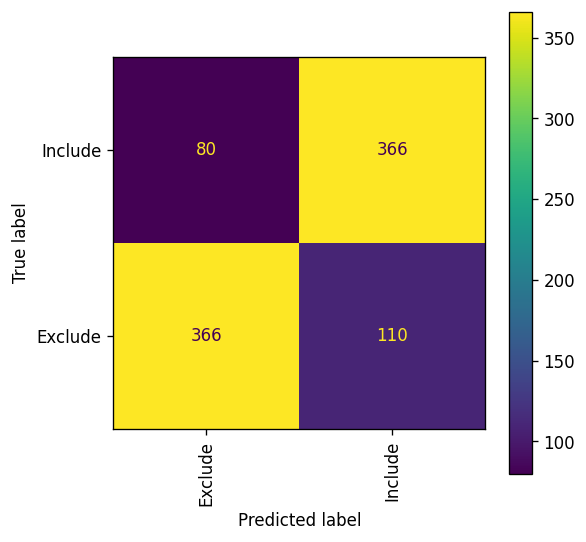

In [14]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
#ax.set_title(col)
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred.argmax(axis=1),
    labels=list(range(len(lnames))),
    display_labels=lnames,
    xticks_rotation='vertical',
    ax=ax
)
ax.invert_yaxis()
fig.show()

/home/galm/Documents/nacsos-2-pipelines/nacsos-support/.venv/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


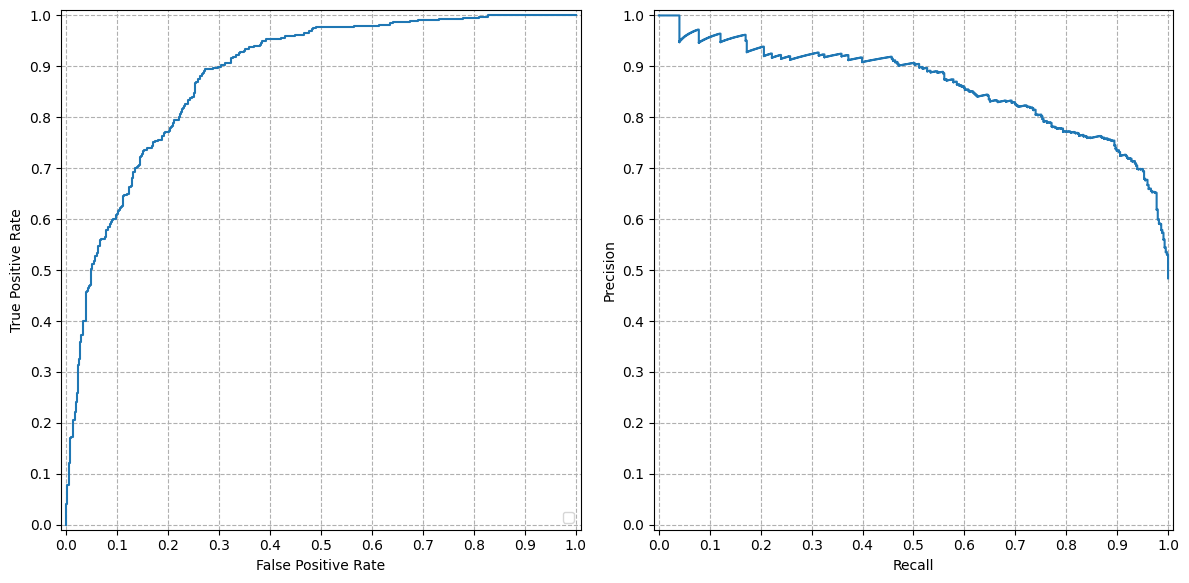

In [15]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_scores = df[df['test']==1]['pred_incl|1'].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(visible=True, linestyle='--')
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(visible=True, linestyle='--')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of classifier scores in test set')

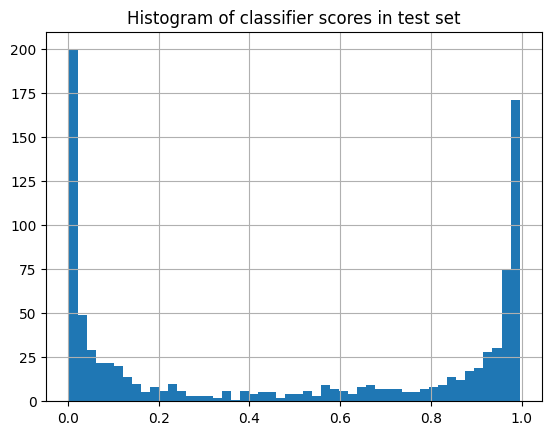

In [16]:
ax = df[df['test']==1]['pred_incl|1'].hist(bins=50)
ax.set_title('Histogram of classifier scores in test set')

### Workload estimation
We'd like to know how much we ne need to annotate. Here, we compute rough estimations based on results from the latest classifier.

In [17]:
pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds.tolist()+[1]}).T

0         1         2         3         4         5    \
precision  0.483731  0.484256  0.484783  0.485310  0.485839  0.486369   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.001685  0.001858  0.001962  0.001993  0.002017  0.002069   

                6         7         8         9         10        11   \
precision  0.486900  0.487432  0.487965  0.488499  0.489035  0.489572   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002196  0.002352  0.002454  0.002486  0.002490  0.002510   

                12        13        14        15        16        17   \
precision  0.490110  0.490649  0.491189  0.491731  0.492274  0.492818   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002523  0.002574  0.002615  0.002633  0.002635  0.002677   

                18        19        20        21        22        23   \
precision  0.493363  0.493909  0.494457  0.495006  0.495556  0.496107   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002742  0.002862  0.002952  0.003004  0.003115  0.003138   

                24        25        26        27        28        29   \
precision  0.496659  0.497213  0.497768  0.498324  0.498881  0.499440   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003138  0.003141  0.003160  0.003183  0.003211  0.003236   

                30        31        32        33        34        35   \
precision  0.500000  0.500561  0.501124  0.501687  0.502252  0.502818   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003267  0.003276  0.003320  0.003376  0.003385  0.003461   

                36        37        38        39        40        41   \
precision  0.503386  0.503955  0.504525  0.505096  0.505669  0.506243   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003503  0.003507  0.003535  0.003542  0.003553  0.003601   

                42        43        44        45        46        47   \
precision  0.506818  0.507395  0.507973  0.508552  0.509132  0.509714   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003611  0.003626  0.003821  0.003847  0.003854  0.003879   

                48        49        50        51        52        53   \
precision  0.510297  0.510882  0.511468  0.512055  0.512644  0.513234   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003930  0.004018  0.004028  0.004326  0.004359  0.004377   

                54        55        56        57        58        59   \
precision  0.513825  0.514418  0.515012  0.515607  0.516204  0.516802   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004402  0.004424  0.004499  0.004501  0.004588  0.004615   

                60        61        62        63        64        65   \
precision  0.517401  0.518002  0.518605  0.519208  0.519814  0.520420   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004644  0.004727  0.004826  0.004881  0.004909  0.004918   

                66        67        68        69        70        71   \
precision  0.521028  0.521637  0.522248  0.522860  0.523474  0.524089   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004929  0.004932  0.005002  0.005018  0.005121  0.005315   

                72        73        74        75        76        77   \
precision  0.524706  0.525324  0.525943  0.526564  0.527187  0.527811   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.005408  0.005455  0.005465  0.005560  0.005596  0.005677   

                78        79        80        81        82        83   \
precision  0.528436  0.529063  0.529691  0.530321  0.530952  0.530393   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  

In [18]:
for TARGET_RECALL in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
    print('=================================')
    print(f'Stats for target recall of {TARGET_RECALL}')
    print('=================================')
    print('> Stats on test set')
    idx = np.argwhere(recall > TARGET_RECALL).max()
    print('idx', idx)
    print('num test items:', len(y_pred))
    print('threshold', thresholds[idx])
    print('precision', precision[idx])
    print('recall', recall[idx])
    print('num above threshold:', (y_pred >= thresholds[idx]).sum())
    print('num below threshold:', (y_pred < thresholds[idx]).sum())
    print('approx. false negative:', int(len(y_pred) * (1 - recall[idx])))
    print('approx. false positive:', int((y_pred >= thresholds[idx]).sum() * (1 - precision[idx])))
    print()
    
    print('> Extrapolation')
    
    mask_new = df['import_upd'] & ~df['import_orig']
    mask_th = df['pred_incl|1'] > thresholds[idx]
    n_incl = (mask_th & mask_new).sum()
    r = recall[idx]
    p = precision[idx]
    
    print(f'Total documents: {df.shape[0]:,}')
    print(f'Original: { df['import_orig'].sum():,}, new query: {df['import_upd'].sum():,}')
    print(f'New query (excl orig): {mask_new.sum():,}')
    print(f'Num documents above threshold: {mask_th.sum():,}, num new docs above threshold: {n_incl:,}')
    print(f'Extrapolating false negatives based on test recall: {int(mask_new.sum() * (1-r)):,}')
    print(f'Extrapolating false positives based on test precision: {int(n_incl * (1-p)):,}')

    print()

Stats for target recall of 0.7
> Stats on test set
idx 543
num test items: 922
threshold 0.8093572
precision 0.8258575197889182
recall 0.7017937219730942
num above threshold: 754
num below threshold: 1090
approx. false negative: 274
approx. false positive: 131

> Extrapolation
Total documents: 6,521
Original: 2,908, new query: 5,528
New query (excl orig): 3,350
Num documents above threshold: 2,040, num new docs above threshold: 958
Extrapolating false negatives based on test recall: 998
Extrapolating false positives based on test precision: 166

Stats for target recall of 0.75
> Stats on test set
idx 506
num test items: 922
threshold 0.6921423
precision 0.8052884615384616
recall 0.7511210762331838
num above threshold: 824
num below threshold: 1020
approx. false negative: 229
approx. false positive: 160

> Extrapolation
Total documents: 6,521
Original: 2,908, new query: 5,528
New query (excl orig): 3,350
Num documents above threshold: 2,199, num new docs above threshold: 1,032
Extrapola

## Assignment
This section of the notebook can be run independently of the previous sections as it loads data from the file we saved before (assuming to ran the imports from the very first cell).

### Data loading
Fetching which items were previously assigned from the database and load the predictions from the file.

**Adjust** the filename!

In [19]:
with db_engine.session() as session:
    rslt = session.execute(select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    print(len(rslt))
assigned_item_ids = [str(r) for r in rslt]

4613


In [20]:
df = pd.read_feather(f'data/screening_round_{training_round}.arrow')
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

### Assignment stats
We'd like to know how much data we still have to assign. The following cell computes that per category of queries. It also estimates how much data there's still to annotate (>0.5 threshold)

In [21]:
masks = [
    ('waste', 'waste', df['Updated Query (11.07.2024) | < 2022 | Waste'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Waste'].astype(bool)),
    ('buildings', 'build', df['Updated Query (11.07.2024) | < 2022 | Buildings'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Buildings'].astype(bool)),
    ('transport', 'trans', df['Updated Query (11.07.2024) | < 2022 | Transport'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Transport'].astype(bool)),
    ('bikes', 'bikes', df['Updated Query (11.07.2024) | < 2022 | Bikes'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Bikes'].astype(bool)),
    ('urban form', 'urban', df['Updated Query (11.07.2024) | < 2022 | Urban form'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Urban form'].astype(bool))
]
mask_assigned = df['item_id'].isin(assigned_item_ids).astype(bool)
mask_glob = ~df['import_orig'].astype(bool) & df['import_upd'].astype(bool)

print('Sanity checks:')
print('Global filter', (~df['import_orig'].astype(bool) & df['import_upd'].astype(bool)).sum())
print(f'Assigned: {mask_assigned.sum():,}, not assigned: {(~mask_assigned).sum():,}')
print(f'Assigned (new): {(mask_assigned & mask_glob).sum():,}, not assigned: {(~mask_assigned & mask_glob).sum():,}')
c = 0
m = None
dfs = df[~df['import_orig']].sort_values('pred_incl|0').head(n=100)
for a, _, b in masks:
    b = b & ~df['import_orig']
    t1h = dfs.index.isin(df[b].index)
    t2h = dfs.index.isin(df[b & ~mask_assigned].index)
    print(f'subfilter mask "{a}": {b.sum():,} (above 0.5 threshold: {(b & (df['pred_incl|1']>0.5)).sum()}, in top 100: {t1h.sum():,})')
    print(f'       > unassgined: {(b & ~mask_assigned).sum():,} (above 0.5 threshold: {(b & (df['pred_incl|1']>0.5) & ~mask_assigned).sum()}, in top 100: {t2h.sum():,})')
    if m is None:
        m = b
    else:
        m |= b
    c += b.sum()
print('sum', c)
print('ORed masks', m.sum())

Sanity checks:
Global filter 3350
Assigned: 4,613, not assigned: 1,908
Assigned (new): 1,790, not assigned: 1,560
subfilter mask "waste": 102 (above 0.5 threshold: 68, in top 100: 2)
       > unassgined: 2 (above 0.5 threshold: 0, in top 100: 0)
subfilter mask "buildings": 829 (above 0.5 threshold: 472, in top 100: 31)
       > unassgined: 153 (above 0.5 threshold: 2, in top 100: 0)
subfilter mask "transport": 980 (above 0.5 threshold: 415, in top 100: 30)
       > unassgined: 249 (above 0.5 threshold: 2, in top 100: 0)
subfilter mask "bikes": 1,611 (above 0.5 threshold: 299, in top 100: 58)
       > unassgined: 1,148 (above 0.5 threshold: 1, in top 100: 0)
subfilter mask "urban form": 731 (above 0.5 threshold: 306, in top 100: 15)
       > unassgined: 143 (above 0.5 threshold: 0, in top 100: 0)
sum 4253
ORed masks 3350


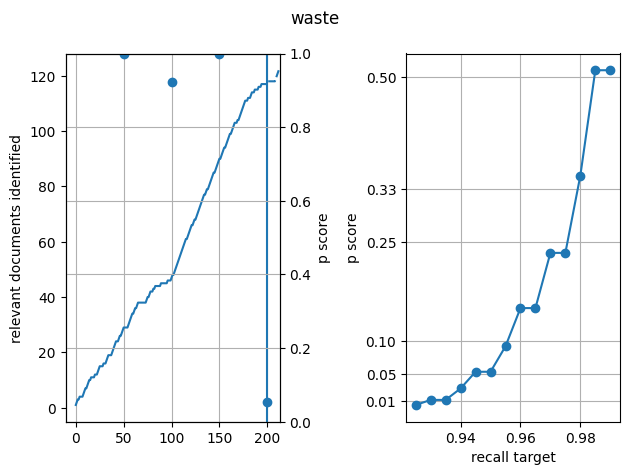

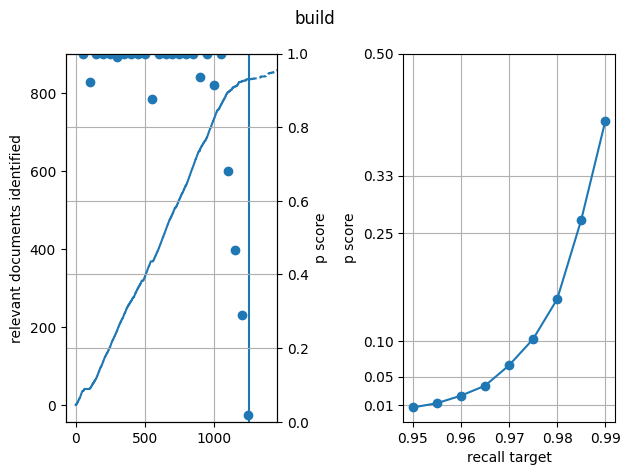

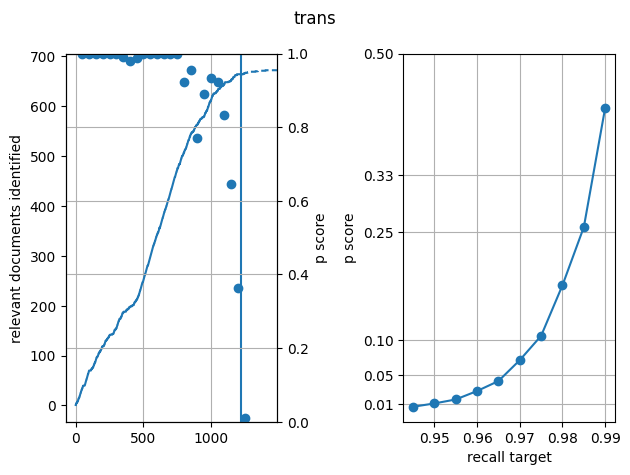

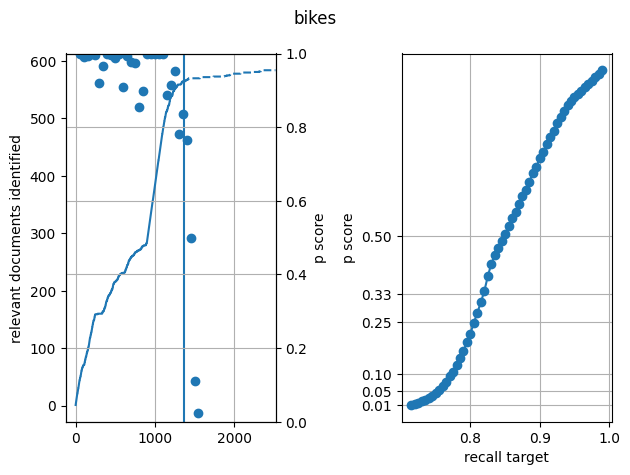

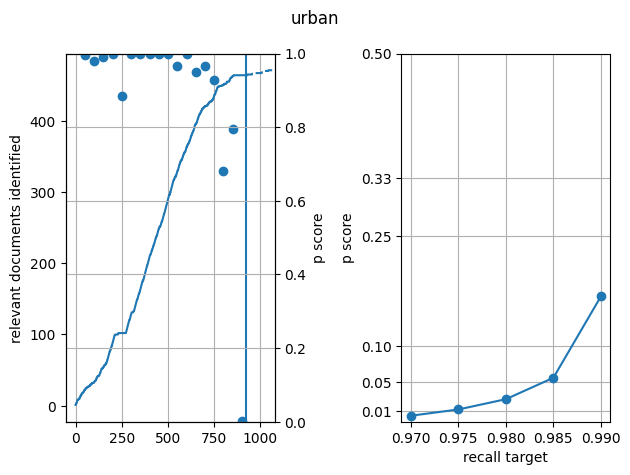

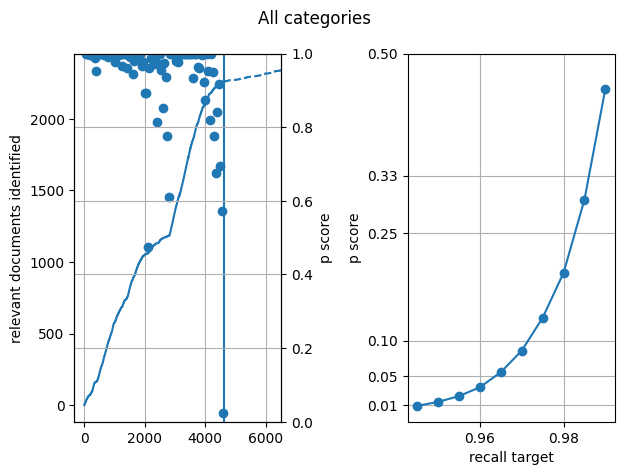

In [22]:
from buscarpy import retrospective_h0, recall_frontier


stmt = text(f'''
SELECT assignment_scope_id, ass.time_created FROM assignment_scope ass RIGHT JOIN
            annotation_scheme ans ON  ass.annotation_scheme_id=ans.annotation_scheme_id WHERE
            ans.project_id='{PROJECT_ID}' ORDER BY ass.time_created;
''')
i = 0
order = []
with db_engine.session() as session:
    rslt = session.execute(stmt).mappings().all()
    for r in rslt:
        asi = r['assignment_scope_id']
        stmt = text(f'''
                SELECT "order", item_id FROM assignment WHERE assignment_scope_id='{asi}'
                ORDER BY "order";
                ''')
        order_rslt = session.execute(stmt).mappings().all()
        for o in order_rslt:
            order.append({'item_id': str(o['item_id']), 'order': i})
            i+=1
order_df = pd.DataFrame.from_dict(order).drop_duplicates(subset='item_id')

df = df.merge(order_df,how='left')

       

def plot_h0(sub_df, axs):

    ax = axs[1]
    r = recall_frontier(sub_df['incl'].dropna(), sub_df.shape[0], plot=False)
    ax.plot(r['recall_target'], r['p'], marker='o')
    ax.set_ylabel('p score')
    ax.set_xlabel('recall target')
    ax.set_yticks([0.01,0.05,0.1,0.25,0.33,0.5])
    ax.grid()

    s_index = pd.notna(sub_df['incl'])
    r_screened = sub_df['incl'].sum()
    ax = axs[0]
    ax.plot(sub_df['incl'].cumsum())
    ax.axvline(s_index.sum())
    u_index = (pd.isna(sub_df['incl'])) & (sub_df.index > s_index.sum())
    preds = np.random.binomial(1,sub_df.loc[u_index,'pred_incl|1'], u_index.sum())
    sub_df.loc[u_index, 'incl'] = preds
    ax.plot(sub_df.loc[u_index,'incl'].cumsum()+r_screened, color='C0', ls='--')

    ax.set_xlim(xmax=sub_df.shape[0])
    p = retrospective_h0(sub_df['incl'].dropna(), sub_df.shape[0], batch_size=50, plot=False)
    ax2 = ax.twinx()
    ax2.scatter(p['batch_sizes'], p['p'])
    ax2.set_ylim(ymax=1, ymin=0)
    ax2.set_ylabel('p score')
    ax.set_ylabel('relevant documents identified')
    ax.grid(axis='x')
    ax2.grid()

for name, key, mask in masks:
    sub_df = df[mask].sort_values('order').reset_index(drop=True)
    fig, axs = plt.subplots(1,2)
    plot_h0(sub_df, axs)
    plt.suptitle(key)
    fig.tight_layout()

sub_df = df.sort_values('order').reset_index(drop=True)
fig, axs = plt.subplots(1,2)
plot_h0(sub_df, axs)
plt.suptitle('All categories')
fig.tight_layout()


In [23]:
# Set all as unassigned
df['assigned'] = mask_assigned

In [24]:
df[masks[0][2]]['assigned'].sum()

200

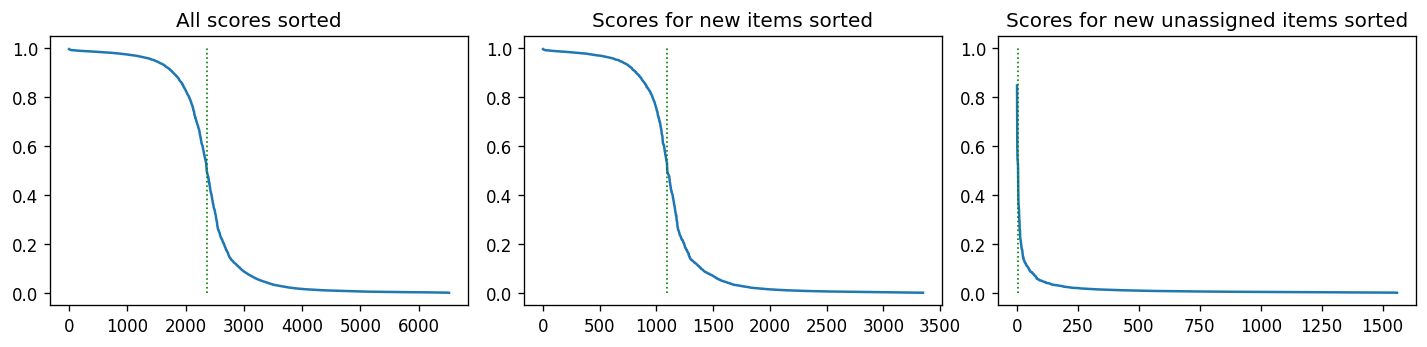

In [25]:
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), dpi=120)

y = np.array(sorted(df['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax1.plot(y)
ax1.vlines(x,0,1, colors='green', ls=':', lw=1)
ax1.set_title('All scores sorted')

y = np.array(sorted(df[df['import_upd'] & ~df['import_orig']]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax2.plot(y)
ax2.vlines(x,0,1, colors='green', ls=':', lw=1)
ax2.set_title('Scores for new items sorted')

y = np.array(sorted(df[~mask_assigned & mask_glob]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax3.plot(y)
ax3.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax3.set_title('Scores for new unassigned items sorted')

fig.tight_layout()

### Create assignments
Here, we finally create the assignments (and a new assignment scope). This expects that you ran everything in the *Assignment* section of this notebook up to this point. Note, that the database connection might be stale after a long training cycle, so executing this cell might hang. In this case, restart the kernel and execute all *Assignment* cells again.

Note, that there's a security switch `DRY_RUN` in this cell. This prevents you from accidentally creating assignments. You should test this cell with `True` first. When everything looks as expected, run it with `False` and change it right back again.

**Adjust** `title`, `desc`, `LIMIT`, `users`, and if needed the inner loop logic.   
The convention for the title is `[date]_[method]_[query]_[annotators]`

In [26]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = False

LIMIT = 70
NUM_PER_ITEM = 2

users = [
    ('josefine.hintz', JOSEFINE),
    #('nikola.milojevic', NIKOLA),
    #('felix.creutzig', FELIX),
    ('freda.pachter', FREDA),
]

# sorted newly imported by relevance (highest inclusion first)
srtd = df[~df['import_orig']].sort_values('pred_incl|0')

skip_masks = {'waste','build','trans','urban'}

with db_engine.session() as session:
    for name, key, mask in masks:
        if key in skip_masks:
            continue

        title = f'{date.today()}_prioritised_{key}'
        desc = f'Top {LIMIT} documents predicted, filtered for the "{name}" query (possibly excluding when higher-ranked ones if seen by other queries)'

        scope_id = str(uuid.uuid4())
        print(f'Creating scope "{title}" with ID {scope_id}')
        if not DRY_RUN:
            scope = AssignmentScope(
                assignment_scope_id=scope_id,
                annotation_scheme_id=SCHEME_ID,
                name=title,
                description=desc
            )
            session.add(scope)
            session.flush()

        scope_mask = srtd.index.isin(df[mask & ~df['import_orig'] & ~df['assigned']].index)

        cnt = 0
        for di, (ri, row) in enumerate(srtd[scope_mask].head(LIMIT).iterrows()):
            item_id = row['item_id']
            
            if not DRY_RUN:
                df.loc[ri, 'assigned'] = True

            #print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')

            for ui in range(NUM_PER_ITEM):  # Number of annotators per item
                username, user_id = users[(di + ui) % len(users)]  
                assi_id = uuid.uuid4()
                
                if not DRY_RUN:
                    assi = Assignment(assignment_id=assi_id,
                                      assignment_scope_id=scope_id,
                                      user_id=user_id,
                                      item_id=item_id,
                                      annotation_scheme_id=SCHEME_ID,
                                      status=AssignmentStatus.OPEN,
                                      order=di)
                    session.add(assi)
                    session.flush()
                cnt += 1
                #print(f'  -> {username} via {assi_id} for scope {scope_id}')
        print(f'Created {cnt} assignments!')


Creating scope "2024-08-12_prioritised_bikes" with ID 2d164a99-12d6-42eb-a6a0-b90a3a2d9a23
Created 140 assignments!


In [27]:
df['assigned'].sum()

4683

### Storing assignments
We'd like to keep the assignments outside of the platform if we need it again. 

**Adjust** the filename by increasing the counter by 1.

In [28]:
df.to_feather(f'data/screening_round_{training_round}_post.arrow')

In [ ]:
stmt = text(f'''
SELECT assignment_scope_id, ass.time_created FROM assignment_scope ass RIGHT JOIN
            annotation_scheme ans ON  ass.annotation_scheme_id=ans.annotation_scheme_id WHERE
            ans.project_id='{PROJECT_ID}' ORDER BY ass.time_created;
''')
i = 0
order = []
with db_engine.session() as session:
    rslt = session.execute(stmt).mappings().all()